In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
%matplotlib inline
import sklearn

### Current samples times above the threshold

In [16]:
ds1 = pd.read_csv('data/AllSites.csv')
threshold = np.where(ds1['NP_Cya_bio'] >= 4e8)
target = np.zeros(len(ds1['NP_Cya_bio']))
target[threshold] = 1
ds1['target'] = pd.Series(target)
# ds1 = ds1.dropna(axis=0, how='any')
ds1 = ds1.dropna(axis=0, subset = ['NP_Cya_bio'])

In [17]:
t = np.where(ds1['target'] == 1.0)
len(ds1.iloc[t])

20

### Using regex capture groups to clean 'H's' out of data

In [18]:
print_data = False
show_positive_cases = False
ds2 = ds1.drop(['Station', 'Stratum','Date','StationID','Time'], axis=1)

# ds2
ds2['Depth'] = ds1['Depth'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TP'] = ds1['TP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Cl'] = ds1['Cl'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['DP'] = ds1['DP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TN'] = ds1['TN'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['TempC'] = ds1['TempC'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Chla'] = ds1['Chla'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['Secchi'] = ds1['Secchi'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
ds2['N:P'] = ((ds2['TN']*1e-3)/14.007)/((ds2['TP']*1e-6)/30.974) #for TN in ds2['TN'] for TP in ds2['TP']]
ds2['date'] = ds1['Date'].astype(str).str.extract('(\d+)').astype(int) # This is just the month number
ds2 = ds2.drop(['NP_Cya_bio'], axis=1)
ds2 = ds2.fillna(value=0)

y = np.array(ds2['target'])
X = np.array(ds2.drop(['target'], axis=1))
for i, x in enumerate(X.T):
    print(np.nanmean(x))
    if i == 8:
        X[:,i]=np.nan_to_num(x,nan=0,posinf=0,neginf=0)
    else:
        X[:,i]=np.nan_to_num(x,nan=np.nanmean(x),posinf=np.nanmean(x),neginf=np.nanmean(x))
# X=np.nan_to_num(X,nan=0,posinf=0,neginf=0)
if show_positive_cases:
    ds1.iloc[t]
if print_data:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(ds2)
ds2.drop(['target'], axis=1)

6.455345911949686
25.48357791754018
13.021802935010482
12.14577218728162
0.40932914046121593
16.490076869322152
6.869986023759609
3.39664570230608
44.71051524549778
7.165618448637317


,Depth,TP,DP,Cl,TN,TempC,Chla,Secchi,N:P,date
0,2.0,39.2,16.2,13.0,0.61,0.0,1.41,0.5,34.410892,4
1,2.2,36.8,14.8,17.5,0.45,13.7,9.67,1.1,27.040633,5
2,2.0,50.1,27.4,12.1,0.55,14.5,2.04,0.7,24.276000,5
4,2.0,59.6,32.6,12.0,0.65,17.7,4.13,0.6,24.116777,6
5,1.2,77.3,47.9,10.5,0.62,22.5,1.74,0.6,17.736355,6
...,...,...,...,...,...,...,...,...,...,...
3629,2.2,53.4,16.8,8.0,0.69,25.6,27.50,1.1,28.573274,8
3631,2.0,83.4,33.9,8.3,0.71,23.7,23.94,1.0,18.825411,9
3632,2.0,94.2,40.7,8.7,0.90,22.3,50.16,1.0,21.127289,9
3634,2.8,68.8,42.6,9.6,0.74,13.4,10.22,1.4,23.784578,10


In [19]:
from sklearn import preprocessing
def split_data(X,y):
    ytp=0
    while ytp < 5:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
        y_train_pos = np.where(y_train == 1)
        y_test_pos= np.where(y_test == 1)
        ytp = len(y_test_pos[0])
    assert len(y_test_pos[0]) >= 5, "Need at least 5 positive samples in training set"
    return X_train, X_test, y_train, y_test,  len(y_train_pos[0])

scale = lambda x : preprocessing.scale(x)


### SVM
Using SVM to find optimal hyperparamters for our dataset.  Scoring using recall.

In [13]:
# change from normalize to scale 
# eval with ROC AUC stuff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
# Separate test and training sets

X_train, X_test, y_train, y_test, y_train_pos = split_data(X, y)

loo = LeaveOneOut() # Specify cross-val technique
X_train_normalized = scale(X_train) # normalize X for processing
svm_classifer = svm.SVC()
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# kernels = ['linear']
scoring = make_scorer(recall_score, zero_division=0) # using two scroing metrics for training and testing 
best_estimators = []
distros = dict(C=np.logspace(-3, 2, 5), 
               gamma=np.logspace(-9, 1, 8), 
               degree=[2,3,4], 
               coef0=[-2,-1,0,1,2],
              class_weight=['balanced', None])

# Perform Random search CV to find best params
for kernel in kernels:
    print(f'KERNEL: {kernel}')
    svm_classifer = svm.SVC(kernel=kernel, cache_size=2000)
    print('optimizing hyperparams...') # Parrallelizing several model classifcations 
    search = RandomizedSearchCV(svm_classifer, distros, scoring=scoring, verbose=5, cv=y_train_pos, n_iter=800, n_jobs=4, pre_dispatch='2*n_jobs')
    search = search.fit(X_train_normalized, y_train)
    best_estimators.append(search.best_estimator_)
    
for ii, estimator in enumerate(best_estimators):
    # we want to fit the best estimator
    # then test it, look for recall and AUC
    # print confusion matrix
    estimator.fit(X_train_normalized, y_train)
    X_test_normalized = scale(X_test)
    y_predict = estimator.predict(X_test_normalized)
    recall = metrics.recall_score(y_test, y_predict, zero_division=0)
    auc = metrics.roc_auc_score(y_test, y_predict)
    print('========================================')
    print(f'KERNEL: {kernels[ii]}')
    print('----------------------------------------')
    print(f'RECALL: {recall}')
    print(f'ROC AUC: {auc}')
    print(metrics.confusion_matrix(y_test, y_predict))
    # [TN  FP
    #  FN TP ]

KERNEL: linear
optimizing hyperparams...
Fitting 15 folds for each of 800 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.7s


KeyboardInterrupt: 

In [ ]:
print(best_estimators)

In [ ]:
import scikitplot as skplt
from sklearn import svm

X_train, X_test, y_train, y_test = split_data(X, y)
model = svm.SVC(C=0.31622776601683794, break_ties=False, cache_size=2000,
    class_weight='balanced', coef0=-2, decision_function_shape='ovr', degree=4,
    gamma=0.01389495494373139, kernel='rbf', max_iter=-1, probability=True,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

X_train_normalized = scale(X_train) # normalize X for processing
model.fit(X_train_normalized, y_train)
X_test_normalized = scale(X_test)
y_predict = model.predict_proba(X_test_normalized)
skplt.metrics.plot_roc_curve(y_test, y_predict, figsize=(8,8), title_fontsize=18, text_fontsize=14)


### SVM
Using SVM to find optimal hyperparamters for our dataset.  Scoring using AUC and Precision-Recall Curve

In [29]:
# change from normalize to scale 
# eval with ROC AUC stuff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test, y_train_pos = split_data(X, y)

loo = LeaveOneOut() # Specify cross-val technique
X_train_normalized = scale(X_train) # normalize X for processing
svm_classifer = svm.SVC()
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# kernels = ['linear']
scoring = {'AUC': 'roc_auc', 'Avg_precis': make_scorer(average_precision_score)} # using two scroing metrics for training and testing 
# scoring = make_scorer(average_precision_score) # using two scroing metrics for training and testing 

best_estimators = []
distros = dict(C=np.logspace(-3, 2, 5), 
               gamma=np.logspace(-9, 1, 8), 
               degree=[2,3,4], 
               coef0=[-2,-1,0,1,2],
              class_weight=['balanced', None])

# Perform Random search CV to find best params
for kernel in kernels:
    print(f'KERNEL: {kernel}')
    svm_classifer = svm.SVC(kernel=kernel, cache_size=2000)
    print('optimizing hyperparams...') # Parrallelizing several model classifcations 
    search = RandomizedSearchCV(svm_classifer, distros, scoring=scoring, refit='AUC', verbose=5, cv=y_train_pos, n_iter=800, n_jobs=4, pre_dispatch='2*n_jobs')
    search = search.fit(X_train_normalized, y_train)
    best_estimators.append(search.best_estimator_)
    
for ii, estimator in enumerate(best_estimators):
    # we want to fit the best estimator
    # then test it, look for recall and AUC
    # print confusion matrix
    estimator.fit(X_train_normalized, y_train)
    X_test_normalized = scale(X_test)
    y_predict = estimator.predict(X_test_normalized)
    recall = metrics.recall_score(y_test, y_predict, zero_division=0)
    auc = metrics.roc_auc_score(y_test, y_predict)
    print('========================================')
    print(f'KERNEL: {kernels[ii]}')
    print('----------------------------------------')
    print(f'RECALL: {recall}')
    print(f'ROC AUC: {auc}')
    print(metrics.confusion_matrix(y_test, y_predict))
    # [TN  FP
    #  FN TP ]

KERNEL: linear
optimizing hyperparams...
Fitting 15 folds for each of 800 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 138 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 410 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 724 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 1348 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done 2112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 3108 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 3960 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 4812 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 6092 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 7238 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 8634 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 10820 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:  7.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend 

KERNEL: poly
optimizing hyperparams...
Fitting 15 folds for each of 800 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 1096 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 2104 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done 4984 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done 6856 tasks      | elapsed:   55.4s
[Parallel(n_jobs=4)]: Done 9016 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 11464 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


KERNEL: rbf
optimizing hyperparams...
Fitting 15 folds for each of 800 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Done 296 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 1016 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 1664 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 2400 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done 3984 tasks      | elapsed:   53.1s
[Parallel(n_jobs=4)]: Done 5856 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 8016 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 10464 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KERNEL: sigmoid
optimizing hyperparams...
Fitting 15 folds for each of 800 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 590 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 1248 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 2256 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 3552 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 5136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 7008 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 9168 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 11616 tasks      | elapsed:  2.6min


KERNEL: linear
----------------------------------------
RECALL: 1.0
ROC AUC: 0.9361702127659575
[[246  36]
 [  0   5]]
KERNEL: poly
----------------------------------------
RECALL: 1.0
ROC AUC: 0.9397163120567377
[[248  34]
 [  0   5]]
KERNEL: rbf
----------------------------------------
RECALL: 1.0
ROC AUC: 0.9361702127659575
[[246  36]
 [  0   5]]
KERNEL: sigmoid
----------------------------------------
RECALL: 0.0
ROC AUC: 0.5
[[282   0]
 [  5   0]]


[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:  2.7min finished


In [30]:
print(best_estimators)

[SVC(C=0.01778279410038923, break_ties=False, cache_size=2000,
    class_weight='balanced', coef0=-2, decision_function_shape='ovr', degree=4,
    gamma=2.682695795279727e-08, kernel='linear', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False), SVC(C=5.623413251903491, break_ties=False, cache_size=2000,
    class_weight='balanced', coef0=2, decision_function_shape='ovr', degree=3,
    gamma=0.0005179474679231213, kernel='poly', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False), SVC(C=5.623413251903491, break_ties=False, cache_size=2000,
    class_weight='balanced', coef0=0, decision_function_shape='ovr', degree=2,
    gamma=0.0005179474679231213, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False), SVC(C=0.31622776601683794, break_ties=False, cache_size=2000, class_weight=None,
    coef0=2, decision_function_shape='ovr', degree=4,
 

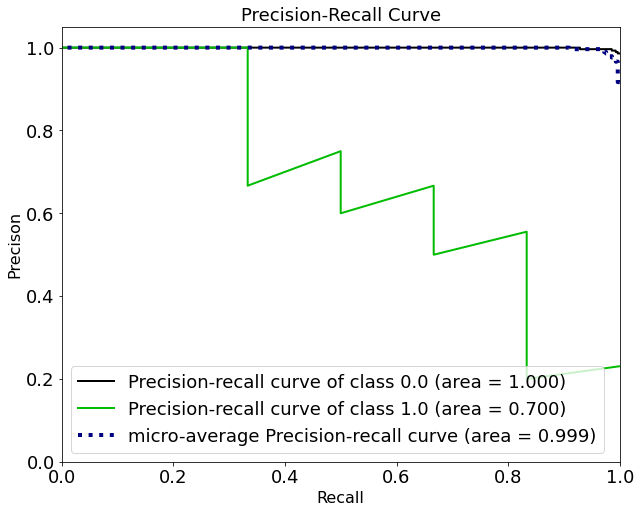

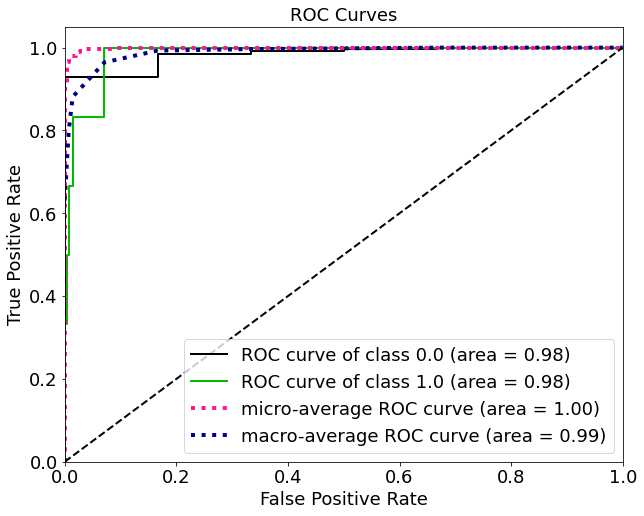

In [31]:
import scikitplot as skplt
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, y_train_pos = split_data(X, y)

model = svm.SVC(C=0.01778279410038923, break_ties=False, cache_size=2000,
    class_weight='balanced', coef0=-2, decision_function_shape='ovr', degree=4,
    gamma=2.682695795279727e-08, kernel='linear', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

# SVC(C=0.001, break_ties=False, cache_size=2000, class_weight='balanced',
#     coef0=-2, decision_function_shape='ovr', degree=4,
#     gamma=7.196856730011529e-07, kernel='linear', max_iter=-1,
#     probability=True, random_state=None, shrinking=True, tol=0.001,
#     verbose=False)
X_train_normalized = scale(X_train) # normalize X for processing
model.fit(X_train_normalized, y_train)
X_test_normalized = scale(X_test)
y_predict = model.predict_proba(X_test_normalized)

skplt.metrics.plot_precision_recall(y_test, y_predict, figsize=(10,8), title_fontsize=18, text_fontsize=18)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precison', fontsize=16)
plt.savefig('figures/precision_recall.png', format='png')

skplt.metrics.plot_roc(y_test, y_predict, figsize=(10,8), title_fontsize=18, text_fontsize=18)
# plt.xlabel('Recall', fontsize=16)
# plt.ylabel('Precison', fontsize=16)
plt.savefig('figures/roc_curve.png', format='png')